In [1]:
import numpy as np
import h5py
import torch
import torchmetrics
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.preprocessing import OneHotEncoder 

from torch.utils.data import Dataset, DataLoader
from torch.nn import BatchNorm1d, Linear, ReLU, Sequential, MSELoss, Softmax, CrossEntropyLoss, Sigmoid
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool
from torch_geometric.data import Batch

path='../project_data/small_set_1_train_0_shuffled.h5'

In [2]:
class HDF5Dataset(Dataset):
    def __init__(self, path, features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", particle_type=13.0, batch_size=16,scaling=None,max_e=None):
        """ Loads the data from the hdf5 format provided by OrcaSong and converts it to data that can be used by PyTorch
        
        Args:
            path (str): path to the dataset
            features (list[str]): List of features to select from the event data and use as input features
            y_feature  (str): Output feature to select
            particle_type (None or float):  ID of the particle you want to classify, it will be label 0 and all else will be label 1.
                                            Must be None when y_feature is not `particle_type`
            batch_size (int): number of samples in mini batch
        Examples:
            Electron vs Background classification (default):
            ```
                HDF5Dataset("pathtodata.h5", y_feature="particle_type", particle_type=13.0)
            ```
            Energy regression with only xyzct:
            ```
                HDF5Dataset("pathtodata.h5", features=["pos_x", "pos_y", "pos_z", "time"], y_feature="energy", particle_type=None)
            ```

        Lookup of table for particle_type of Leptons:
          electron          | 11
          electron neutrino | 12
          muon              | 13
          muon neutrino     | 14
          tau               | 15
          tau neutrino      | 16
        Antiparticle is the same as particle but with minus sign
        Source: https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf
        """
        with h5py.File(path, "r") as f:
            self.groups = list(dict(f).keys())
            if max_e:
                self.ix_lijst = np.where(f["y"]['energy']<max_e)[0]
                self.length = len(self.ix_lijst) // batch_size + 1
                self._max_index = len(self.ix_lijst)
            else:
                self.length =  len(f["y"]) // batch_size + 1
                self._max_index = len(f["y"])
            self.encoder=OneHotEncoder(sparse=False)
            self.encoder.fit(f["y"][:2000]['particle_type'].reshape(-1,1))
            print("The available y features are: ", f["y"][0].dtype.names)
        self.filename = path
        if y_feature!="particle_type":
            assert particle_type==None, "Selected a y_feature other than 'particle_type' and specified some value for particle_type as argument, which must be None for non particle_type output feature."
        self.y_feature = y_feature
        self.particle_type = particle_type
        self.scaling=scaling
        self.batch_size = batch_size
        self.max_e=max_e
        self._cache_x_column_names()
        self.x_mask = self.init_x_mask(features)



    def _cache_x_column_names(self):
        """Cache which columns are available in the features

        Raises:
            ValueError: It failed to read the hit_info columns
        """
        try:
            with h5py.File(self.filename, "r") as f:
                self.x_feature_dict = {
                    f["x"].attrs[f"hit_info_{i}"]: i for i in range(f["x"].shape[-1])
                }
            print("cached the following x input features", self.x_feature_dict)
        except Exception:
            raise ValueError("Can not read column names from dataset attributes")

    def init_x_mask(self, features):
        """Compute a mask that is used to select the feature columns from the data

        Args:
            features (list[str]): list of features present to load

        Returns:
            np.array: selection of column index from the features to use
        """
        x_mask = [self.x_feature_dict[feat] for feat in features]
        return np.array(x_mask)

    def __getitem__(self,index):
        """Get an sample from the h5 dataset
        x contains: (x,y,z,ct, dir_x, dir_y, dir_z)
        y contains a label 

        Args:
            index (int): index of the batch

        Returns:
            x (torch.Tensor): Tensor with the x data (for each of the vertices)
            y (torch.Tensor): Tensor with the y data (for the graph)
            batch_idx (torch.Tensor): Tensor that assigns the right batch index to each x point
        """
        with h5py.File(self.filename, "r") as f:
            ix_list = slice(index * self.batch_size, min(self._max_index,(index + 1) * self.batch_size))
            if self.max_e:
                ix_list = self.ix_lijst[ix_list]
            
            x = f["x"][ix_list]
            part_type= np.abs(f["y"][ix_list]['particle_type'].reshape(-1,1))
            lengths = (np.sum(x[:, :, -1:], axis=1)).astype(int)
            batch_idx = np.hstack(
                                [ np.ones(length) * batch_idx for batch_idx, length in enumerate(lengths) ]
                                )
            x = x[x[:, :, -1] == 1][:, self.x_mask]
            to_stack=np.array([part_type[int(i)] for i in batch_idx]).astype('<f4')
            x=np.hstack([x,to_stack])
            y = f["y"][ix_list][self.y_feature].reshape(-1,1)
            if self.scaling == 'log':
                y = torch.log(torch.Tensor(y.copy()))
            elif np.char.isnumeric(str(self.scaling)):
                y = torch.Tensor(np.clip(y,0,self.scaling)/self.scaling)
            else:
                y = torch.Tensor(y.copy())
        return x, y, torch.LongTensor(batch_idx)

    def __len__(self):
        return self.length

In [3]:
class DECNetwork(pl.LightningModule):
    def __init__(self, batchnorm_kwargs=None, conf=None):
        """Dynamic EdgeConvolution Network https://arxiv.org/abs/1801.07829 with
           the dynamic KNN computation as presented in https://arxiv.org/abs/1902.08570 """
        super().__init__()
        ## Lightning configuration
        #self.accuracy = pl.metrics.Accuracy()
        ## Defining the Network Architecture
        nn = Sequential(
            Linear(2 * 9, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
        )
        self.edge_1 = DynamicEdgeConv(nn, aggr="mean", k=32)
        
        nn = Sequential(
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
        )
        self.edge_2 = DynamicEdgeConv(nn, aggr="mean", k=32)

        self.shortcut_1 = Sequential(Linear(9, 64), BatchNorm1d(64), ReLU())
        self.shortcut_2 = Sequential(Linear(64, 128), BatchNorm1d(128), ReLU())


        self.lin_2 = Linear(128, 128)
        self.lin_3 = Linear(128, 1)
        
    
    def forward(self, data):
        x, batch_idx = data.x, data.batch
        # in lightning, forward defines the prediction/inference actions
        # edgeconv layer 1
        sc = self.shortcut_1(x)
        x = self.edge_1(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 2
        sc = self.shortcut_2(x)
        x = self.edge_2(x, batch_idx)
        x = F.relu(x + sc)
      
        x = global_mean_pool(x, batch=batch_idx)
        # now apply

        x = F.relu(self.lin_2(x))
        x = self.lin_3(x)
        return torch.sigmoid(x).squeeze()
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        out = self.forward(batch)
        loss = F.mse_loss(out, batch.y)
        self.log("train_loss", loss)
        #self.log('train_acc_step', self.accuracy(out, batch.y), on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
        self.log("val_loss", loss)
        #self.log('valid_acc', self.accuracy(y_hat, batch.y), on_step=True, on_epoch=True)
        #self.log('valid_matrix', self.confusionmatrix(F.softmax(y_hat), batch.y), on_epoch=True)
    
    def test_step(self,batch,batch_idx):
        batch = Batch(
            x=batch[0].squeeze(),y=batch[1].squeeze(),batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
        predictions_pred.append(y_hat)
        predictions_actual.append(batch.y)
        
        self.log("test_loss", loss)
        #self.log('test_acc', self.accuracy(y_proba, batch.y), on_step=True, on_epoch=True)
        return {'test_loss': loss, 'y': batch.y, 'y_pred': y_hat}
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [4]:
features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"]
train_data = HDF5Dataset(path,features=features, y_feature="energy",particle_type=None, batch_size=16,scaling=45,max_e=40)

train_loader = DataLoader(
    train_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

val_data = HDF5Dataset("../project_data/small_set_1_validate_0_shuffled.h5",features=features, y_feature="energy",particle_type=None, batch_size=32,scaling=45,max_e=40)

val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

model = DECNetwork()

The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}
The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 

In [5]:
trainer = pl.Trainer(
    max_epochs=20,
    gpus=1,
    precision=32,
    log_every_n_steps=1000,
    progress_bar_refresh_rate=100,
    fast_dev_run=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [97]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | edge_1     | DynamicEdgeConv | 9.9 K 
1 | edge_2     | DynamicEdgeConv | 50.3 K
2 | shortcut_1 | Sequential      | 768   
3 | shortcut_2 | Sequential      | 8.6 K 
4 | lin_2      | Linear          | 16.5 K
5 | lin_3      | Linear          | 129   
-----------------------------------------------
86.2 K    Trainable params
0         Non-trainable params
86.2 K    Total params
0.345     Total estimated model params size (MB)


Epoch 0:  71%|███████   | 1400/1982 [00:59<00:24, 23.40it/s, loss=0.0236, v_num=70]
Validating: 0it [00:00, ?it/s]
Epoch 1:  71%|███████   | 1400/1982 [01:00<00:24, 23.33it/s, loss=0.0232, v_num=70]
Validating: 0it [00:00, ?it/s]
Epoch 2:  71%|███████   | 1400/1982 [00:59<00:24, 23.37it/s, loss=0.0226, v_num=70]
Validating: 0it [00:00, ?it/s]
Epoch 3:  71%|███████   | 1400/1982 [01:00<00:24, 23.29it/s, loss=0.0217, v_num=70]
Validating: 0it [00:00, ?it/s]
Epoch 4:  71%|███████   | 1400/1982 [01:00<00:24, 23.29it/s, loss=0.0213, v_num=70]
Validating: 0it [00:00, ?it/s]
Epoch 5:  71%|███████   | 1400/1982 [01:00<00:25, 23.25it/s, loss=0.0207, v_num=70]
Validating: 0it [00:00, ?it/s]
Epoch 6:  71%|███████   | 1400/1982 [00:59<00:24, 23.38it/s, loss=0.0206, v_num=70]
Validating: 0it [00:00, ?it/s]
Epoch 7:  71%|███████   | 1400/1982 [00:59<00:24, 23.37it/s, loss=0.0203, v_num=70]
Validating: 0it [00:00, ?it/s]
Epoch 8:  71%|███████   | 1400/1982 [00:59<00:24, 23.38it/s, loss=0.0201, v_num=

1

In [98]:
trainer.save_checkpoint(trainer.log_dir+"/trained_model.ckpt")

In [6]:
model = DECNetwork().load_from_checkpoint('lightning_logs/version_70/trained_model.ckpt')

Run 70!

In [7]:
val_data = HDF5Dataset("../project_data/small_set_1_validate_0_shuffled.h5",features=features, y_feature="energy",particle_type=None, batch_size=32,scaling=45)

val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
predictions_pred = []
predictions_actual = []
trainer.test(model,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}
Testing: 100%|██████████| 2493/2493 [02:45<00:00, 15.09it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.12838926911354065}
--------------------------------------------------------------------------------


[{'test_loss': 0.12838926911354065}]

In [8]:
y_pred=np.empty(1)
y_actual=np.empty(1)
for i in range(len(predictions_pred)):
    y_pred=np.vstack([y_pred,predictions_pred[i].cpu().numpy().reshape(-1,1)])
    y_actual=np.vstack([y_actual,predictions_actual[i].cpu().numpy().reshape(-1,1)])

In [102]:
df

,event_id,particle_type,energy,is_cc,bjorkeny,dir_x,dir_y,dir_z,time_interaction,run_id,...,std_pos_y,std_pos_z,std_energy,std_lik_energy,std_length,group_id,pred_energy,true_energy,relative_error_E,particles
3,136,14.0,16.1681,2.0,0.805902,-0.697074,-0.250152,0.671946,5.161513e+07,6574.0,...,6.158989,16.434426,5.221237,54.063477,17.945395,78072,0.0,16.1681,100.0,muon neutrino
5,24,14.0,12.2170,3.0,0.237005,0.625732,0.368598,0.687455,4.117892e+07,6593.0,...,9.211251,82.306007,5.842538,46.239101,17.624361,50890,0.0,12.2170,100.0,muon neutrino
7,44,12.0,5.7854,2.0,0.783570,0.391471,-0.912391,-0.119555,7.745192e+07,6634.0,...,-23.961584,202.446865,5.221237,82.021553,20.587317,45167,0.0,5.7854,100.0,electron neutrino
10,27,12.0,1.3223,2.0,0.462922,-0.244445,0.960991,-0.129395,2.022750e+07,6731.0,...,6.371531,55.689342,1.005637,inf,24.526690,41039,0.0,1.3223,100.0,electron neutrino
17,296,-14.0,4.5954,2.0,0.351109,0.348816,0.847569,0.399943,5.585723e+07,6574.0,...,-22.338226,114.952339,3.483310,61.847775,10.632551,60620,0.0,4.5954,100.0,muon neutrino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79743,60,14.0,7.5536,2.0,0.126654,0.132783,-0.047733,0.989995,6.273384e+07,6574.0,...,-4.989608,13.914456,6.320934,72.580833,24.810429,60384,0.0,7.5536,100.0,muon neutrino
79747,77,14.0,2.2432,3.0,0.818560,-0.092782,-0.953003,0.288403,4.659371e+07,6590.0,...,10.606848,31.972989,1.985416,63.301693,29.213129,51047,0.0,2.2432,100.0,muon neutrino
79748,4,-12.0,1.7188,2.0,0.061668,0.289996,-0.950374,0.112657,5.206157e+07,6589.0,...,3.029715,91.152365,2.323865,19.787069,9.241974,45239,0.0,1.7188,100.0,electron neutrino
79762,42,14.0,7.5547,3.0,0.829013,0.728916,0.494007,0.473960,5.650783e+07,6667.0,...,-10.111739,115.589253,4.772115,43.465649,5.072692,51376,0.0,7.5547,100.0,muon neutrino


In [55]:
import pandas as pd
path="../project_data/small_set_1_validate_0_shuffled.h5"
with h5py.File(path, "r") as f:
    df=pd.DataFrame(f['y'][:])
    #df=df.loc[df.energy<40]
df['pred_energy']=45*y_pred[1:]
df['true_energy']=45*y_actual[1:]
df['rel_error_4']=100*(np.abs(df.true_energy-df.pred_energy)/df.true_energy)
particle_names={-13:'muon',14:'muon neutrino',-14:'muon neutrino',12:'electron neutrino',-12:'electron neutrino'}
df['particles']=df.particle_type.map(particle_names)

In [56]:
df=df.loc[df.energy<40]

In [57]:
df

,event_id,particle_type,energy,is_cc,bjorkeny,dir_x,dir_y,dir_z,time_interaction,run_id,...,std_pos_y,std_pos_z,std_energy,std_lik_energy,std_length,group_id,pred_energy,true_energy,rel_error_4,particles
3,136,14.0,16.1681,2.0,0.805902,-0.697074,-0.250152,0.671946,5.161513e+07,6574.0,...,6.158989,16.434426,5.221237,54.063477,17.945395,78072,19.317871,16.168100,19.481397,muon neutrino
5,24,14.0,12.2170,3.0,0.237005,0.625732,0.368598,0.687455,4.117892e+07,6593.0,...,9.211251,82.306007,5.842538,46.239101,17.624361,50890,8.993187,12.216999,26.387926,muon neutrino
7,44,12.0,5.7854,2.0,0.783570,0.391471,-0.912391,-0.119555,7.745192e+07,6634.0,...,-23.961584,202.446865,5.221237,82.021553,20.587317,45167,3.830677,5.785400,33.787179,electron neutrino
10,27,12.0,1.3223,2.0,0.462922,-0.244445,0.960991,-0.129395,2.022750e+07,6731.0,...,6.371531,55.689342,1.005637,inf,24.526690,41039,1.362686,1.322300,3.054219,electron neutrino
17,296,-14.0,4.5954,2.0,0.351109,0.348816,0.847569,0.399943,5.585723e+07,6574.0,...,-22.338226,114.952339,3.483310,61.847775,10.632551,60620,13.928270,4.595400,203.091582,muon neutrino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79743,60,14.0,7.5536,2.0,0.126654,0.132783,-0.047733,0.989995,6.273384e+07,6574.0,...,-4.989608,13.914456,6.320934,72.580833,24.810429,60384,18.431892,7.553600,144.014667,muon neutrino
79747,77,14.0,2.2432,3.0,0.818560,-0.092782,-0.953003,0.288403,4.659371e+07,6590.0,...,10.606848,31.972989,1.985416,63.301693,29.213129,51047,15.986385,2.243200,612.659850,muon neutrino
79748,4,-12.0,1.7188,2.0,0.061668,0.289996,-0.950374,0.112657,5.206157e+07,6589.0,...,3.029715,91.152365,2.323865,19.787069,9.241974,45239,4.032134,1.718800,134.590089,electron neutrino
79762,42,14.0,7.5547,3.0,0.829013,0.728916,0.494007,0.473960,5.650783e+07,6667.0,...,-10.111739,115.589253,4.772115,43.465649,5.072692,51376,9.422383,7.554700,24.722136,muon neutrino


In [58]:
bins = pd.cut(df.energy,bins=[x*5 for x in range(int(df.energy.max()/5)+2)],labels=[x*5 for x in range(int(df.energy.max()/5)+1)])

In [59]:
data=df[['rel_error_4']].groupby(bins).median()
std=df[['rel_error_4']].groupby(bins).std()
std

,rel_error_4
energy,
0,140.095846
5,56.481877
10,31.281233
15,20.127712
20,19.294494
25,19.834571
30,18.994723
35,15.710459


In [62]:
data2 = pd.read_pickle('experiment3.pkl')
df=data2.join(data)
df/=100

In [64]:
std2 = pd.read_pickle('experiment3_std.pkl')
std=std.join(std2)

In [70]:
df=df.loc[df.index<40]

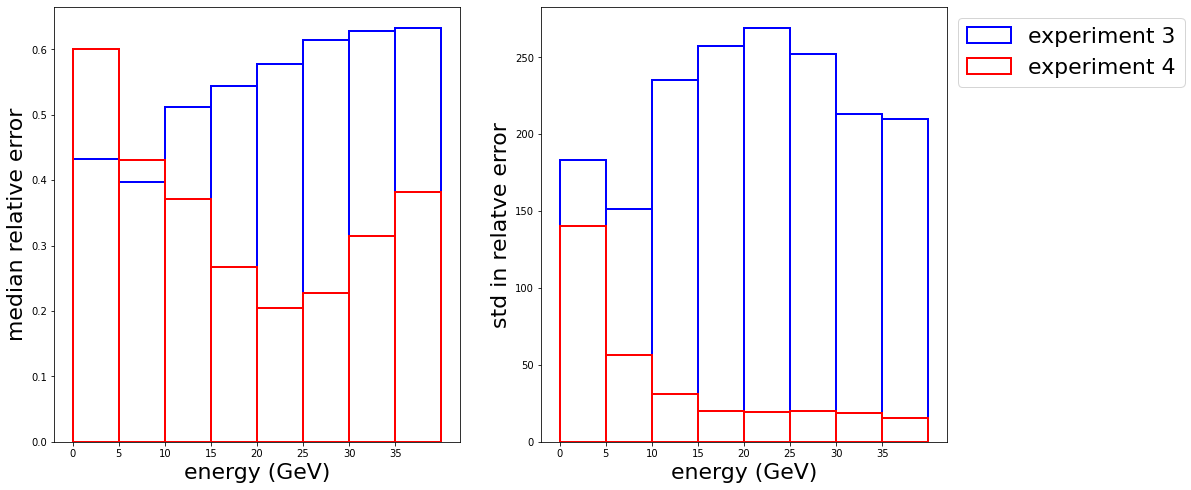

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].bar(df.index,df.rel_error_3,width=5,align='edge',fill=False,edgecolor='b',linewidth=2,tick_label=[x*5 for x in range(8) ],label='experiment 3')
axs[0].bar(df.index,df.rel_error_4,width=5,align='edge',fill=False,edgecolor='r',linewidth=2,tick_label=[x*5 for x in range(8) ],label='experiment 4')
axs[1].bar(std.index,std.rel_error_3,width=5,align='edge',fill=False,edgecolor='b',linewidth=2,tick_label=[x*5 for x in range(8) ],label='experiment 3')
axs[1].bar(std.index,std.rel_error_4,width=5,align='edge',fill=False,edgecolor='r',linewidth=2,tick_label=[x*5 for x in range(8) ],label='experiment 4')
axs[0].set_xlabel('energy (GeV)',fontsize = 22)
axs[1].set_xlabel('energy (GeV)',fontsize = 22)
axs[0].set_ylabel('median relative error',fontsize = 22)
axs[1].set_ylabel('std in relatve error',fontsize = 22)
plt.legend(fontsize = 22,bbox_to_anchor=(1,1), loc="upper left")
plt.show()
fig.savefig("rel_error.pdf")
fig.savefig("rel_error.png")

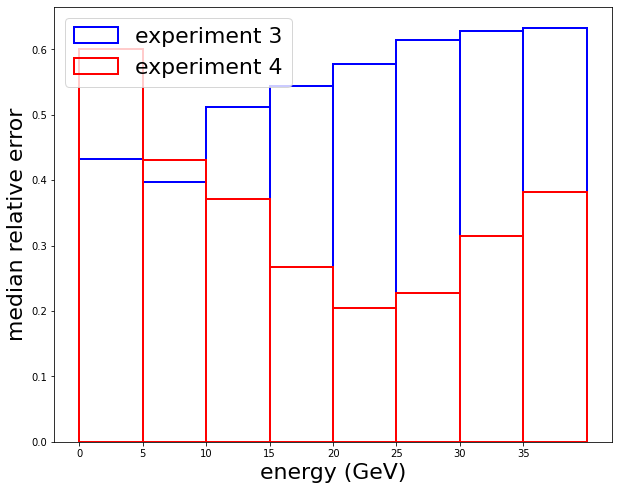

In [51]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.bar(df.index,df.rel_error_3,width=5,align='edge',fill=False,edgecolor='b',linewidth=2,tick_label=[x*5 for x in range(8) ],label='experiment 3')
plt.bar(df.index,df.rel_error_4,width=5,align='edge',fill=False,edgecolor='r',linewidth=2,tick_label=[x*5 for x in range(8) ],label='experiment 4')
plt.xlabel('energy (GeV)',fontsize = 22)
plt.ylabel('median relative error',fontsize = 22)
plt.legend(fontsize = 22,loc='best')
plt.show()
fig.savefig("rel_error.pdf")
fig.savefig("rel_error.png")

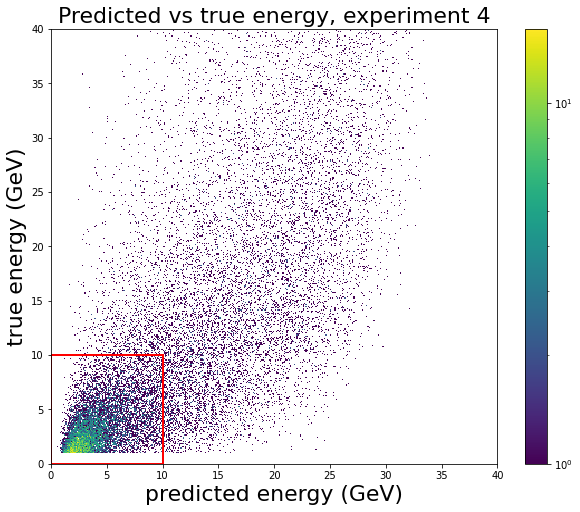

In [185]:
bins=[x/10 for x in range(400)]
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
x=df.pred_energy.values
y=df.energy.values
fig = plt.figure(figsize=(10,8))
_,_,_,axs=plt.hist2d(x,y,[bins,bins],norm=LogNorm(),cmap='viridis')
rect=plt.Rectangle((0,0), 10, 10,fill=False, ec="red",linewidth=2)
plt.gca().add_patch(rect)
plt.colorbar()
plt.xlim([0,40])
plt.ylim([0,40])
plt.title('Predicted vs true energy, experiment 4',fontsize = 22)
plt.xlabel('predicted energy (GeV)',fontsize = 22)
plt.ylabel('true energy (GeV)',fontsize = 22)
plt.show() 
fig.savefig("Energy_hist_exp4.pdf")
fig.savefig("Energy_hist_exp4.png")

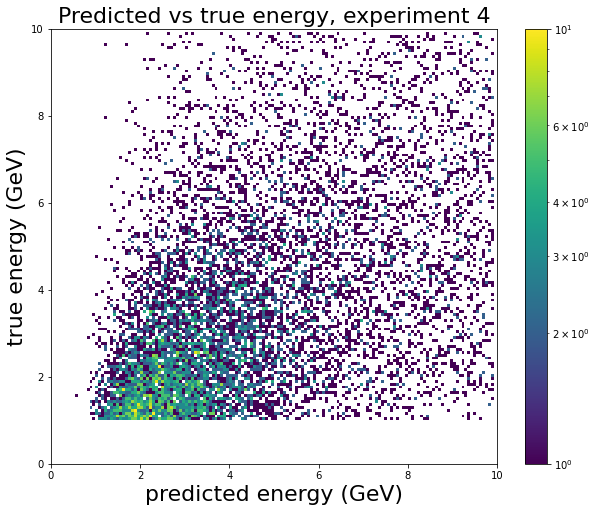

In [182]:
bins=[x/15 for x in range(150)]
fig = plt.figure(figsize=(10,8))
_,_,_,axs=plt.hist2d(x,y,[bins,bins],norm=LogNorm(),cmap='viridis')
plt.colorbar()
plt.xlim([0,10])
plt.ylim([0,10])
plt.title('Predicted vs true energy, experiment 4',fontsize = 22)
plt.xlabel('predicted energy (GeV)',fontsize = 22)
plt.ylabel('true energy (GeV)',fontsize = 22)
plt.show() 
fig.savefig("Energy_hist_exp4_2.pdf")
fig.savefig("Energy_hist_exp4_2.png")